![Astrofisica Computacional](../logo.PNG)

---
## 01. The Image Plane and the Initial Conditions for Many Photons

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Summary

In this notebook we will implement the image plane as the detector for obtaining the black hole image and setup the initial conditions to trace the trajectories of many photons. 


---

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from schwarzschild import *

### Initial Conditions

In [2]:
def initCond(x, k, metric):
    '''
    Given the initial conditions (x,k)
    this function returns the list
    [t, r, theta, phi, k_t, k_r, k_theta, k_phi] 
    with the initial conditions needed to solve 
    the geodesic equations 
    (with the covariant components of the momentum vector)    
    # Coordinates
    t = x[0]
    r = x[1]
    theta = x[2]
    phi = x[3]
    kt = k[0]
    kr = k[1]
    ktheta = k[2]
    kphi = k[3]
    '''
        
    # Metric components
    g_tt, g_rr, g_thth, g_phph = metric(x, M=M)
    
    # Lower k-indices
    k_t = g_tt*k[0] 
    k_r = g_rr*k[1]
    k_th = g_thth*k[2]
    k_phi = g_phph*k[3]
    
    return [x[0], x[1], x[2], x[3], k_t, k_r, k_th, k_phi]

### Image Plane

Given the initial position of a photon in the image plane, $[\alpha, \beta]$, this function calculates the initial position and momentum in spherical coordinates,

\begin{align}
r_0 = &\sqrt{D^2 + \alpha^2 + \beta^2}\\
\theta_0 = & \arccos \left( \frac{D \cos \iota + \beta \sin \iota}{\sqrt{D^2 + \alpha^2 + \beta^2}} \right)\\
\phi_0 = & \arctan \left( \frac{\alpha}{D \sin \iota - \beta \cos \iota} \right)\\
k^r_0 = &\frac{D}{r_0}k_0\\
k^\theta_0 = & \frac{k_0}{\sqrt{r_0^2 - (D\cos \iota + \beta \sin \iota)^2}} \left( \cos \iota - \frac{D}{r_0^2} (D\cos \iota + \beta \sin \iota) \right) \\
k^\phi_0 = & \frac{\alpha \sin \iota k_0}{\alpha^2 + (D\cos \iota + \beta \sin \iota)^2}\\
k^t_0 = & \sqrt{(k^r_0)^2 + r_0^2 (k^\theta _ 0)^2 + r_0^2 \sin^2 \theta_0 (k^\phi _ 0)^2}
\end{align}




In [3]:
def image_plane(alpha, beta, freq, D, iota):
    '''
    Given the initial cartesian coordinates in the image plane 
    (alpha,beta),the distance D to the force center and the 
    inclination angle i, this function calculates the initial 
    spherical coordinates (r, theta, phi) and the initial
    components of the momentum (kt, kr, ktheta, kphi)
    '''
        
    # Transformation from (Alpha, Beta, D) to (r, theta, phi) 
    r = np.sqrt(alpha**2 + beta**2 + D**2)
    theta = np.arccos((beta*np.sin(iota) + D*np.cos(iota))/r)
    phi = np.arctan(alpha/(D*np.sin(iota) - beta*np.cos(iota)))

    #Initial position of the photon in spherical coordinates 
    #(t=0, r, theta, phi)
    xin = [0., r, theta, phi]
                
    
    #Given a frequency value w0, this calculates the initial 
    # 4-momentum of the photon  
    w0 =  freq    
    aux = alpha**2 + (-beta*np.cos(iota) + D*np.sin(iota))**2 
    kr =  (D/r)*w0   
    ktheta = (w0/np.sqrt(aux))*(-np.cos(iota) 
                + (beta*np.sin(iota) + D* np.cos(iota))*(D/(r**2)))  
    kphi = - alpha*np.sin(iota)*w0/aux     
    kt = np.sqrt(kr**2 + r**2 * ktheta**2 + r**2*(np.sin(theta))**2 *kphi**2)
        
    # Initial 4-momentum in spherical coordinates  
    # (kt, kr, ktheta, kphi)
    kin = [kt, kr, ktheta, kphi]
    return xin, kin

## Photon Class


In [4]:
class Photon:
    def __init__(self, alpha=1., beta=0., freq=1., D=100., i = np.pi/4):
        '''
        Given the initial coordinates in the image plane (X,Y), the distance D 
        to the force center and inclination angle i, this calculates the 
        initial coordinates in spherical coordinates (r, theta, phi)
        ''' 
        # Initial Cartesian Coordinates in the Image Plane
        self.alpha = alpha
        self.beta = beta
        self.D = D
        self.iota = i

        #Initial position and momentum in spherical coordinates 
        self.xin, self.kin = image_plane(self.alpha, self.beta, freq, self.D, self.iota)

        #Stores the initial conditions of coordinates and momentum 
        # to solve the geodesic equations.
        self.iC = None


In [5]:
def plot3D(sol):
    '''
    Plots the trajectory of the photon 
    '''
    indx = len(sol[:,1])
    for i in range(indx):
        if sol[i,1]<2.*M +1e-10: 
            indx = i
            break
    # Cartesian coordinates
    x = sol[:indx,1]*np.sin(sol[:indx,2])*np.cos(sol[:indx,3])
    y = sol[:indx,1]*np.sin(sol[:indx,2])*np.sin(sol[:indx,3])
    z = sol[:indx,1]*np.cos(sol[:indx,2])
    
    # Draw the black hole
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    xs = 2*M*np.cos(u)*np.sin(v)
    ys = 2*M*np.sin(u)*np.sin(v)
    zs = 2*M*np.cos(v)
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(xs, ys, zs, color='k')
    ax.scatter(0,0,0, color='black')
    ax.plot(x, y, z, color='crimson')
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_zlim(-15,15)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    plt.show()

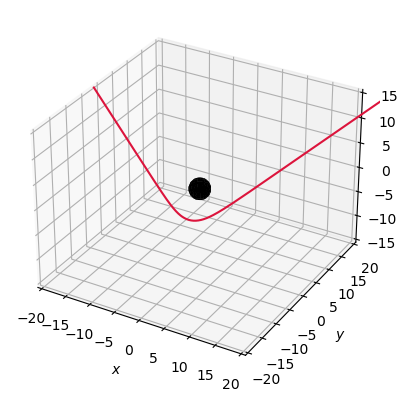

In [6]:
M = 1

# Initial Conditions in the image plane
alpha = -5.
beta = -5.

# Create a photon
p = Photon(alpha=alpha, beta=beta)
p.iC = initCond(p.xin, p.kin, g)


# Independent parameter range
lmbda = np.linspace(0,-150,1000)

# Integration and plot
sol = odeint(geodesics, p.iC, lmbda, args=(M,))
plot3D(sol)

## 